# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Auto-configure CUDA paths for Windows if installed via pip/uv
import os
import platform
import sys

if platform.system() == 'Windows':
    try:
        import nvidia.cudnn.lib
        import nvidia.cublas.lib
        
        cudnn_dir = os.path.dirname(nvidia.cudnn.lib.__file__)
        cublas_dir = os.path.dirname(nvidia.cublas.lib.__file__)
        
        # Add to PATH
        os.environ['PATH'] = cudnn_dir + os.pathsep + cublas_dir + os.pathsep + os.environ['PATH']
        
        # Also, we might need 'bin' dirs for some packages if they structure it that way
        # But nvidia-cudnn-cu11 on pypi usually puts dlls in the package dir or lib dir.
        print(f"Added CUDA paths: {cudnn_dir}")
    except ImportError:
        print("NVIDIA python packages not found, falling back to system PATH for CUDA.")


# Load Python Libraries
import math
from tensorflow import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
import tensorflow as tf
tf.random.set_seed(42)

NVIDIA python packages not found, falling back to system PATH for CUDA.


In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date

In [5]:
# Plot the Close Data

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
print(data.isnull().sum())

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
data.fillna(method='ffill', inplace=True)

C:\Users\fady8\AppData\Local\Temp\ipykernel_35312\2866031220.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [8]:
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


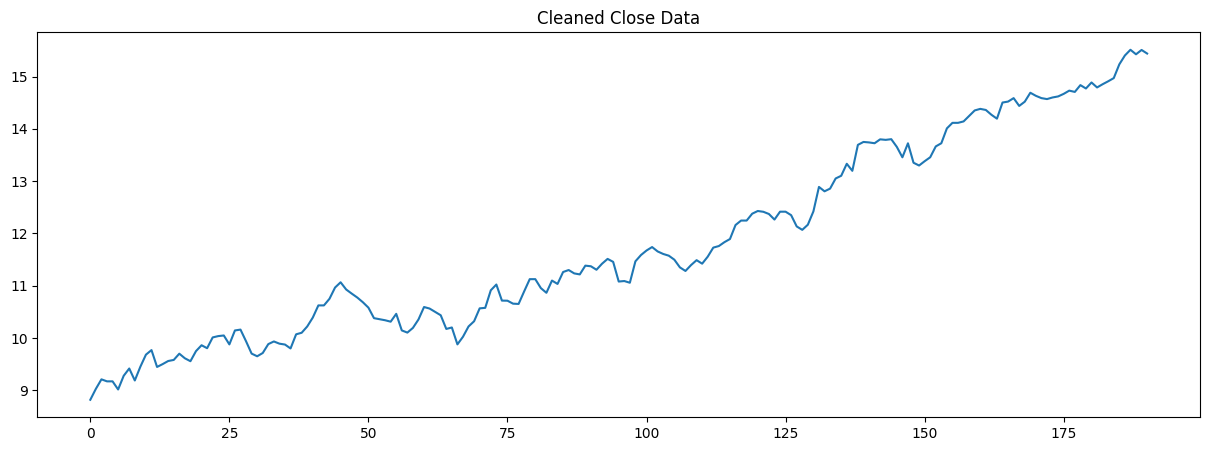

In [9]:
plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.title('Cleaned Close Data')
# plt.savefig('img/cleaned_close_data.png')
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['MA20'] = data['Close'].rolling(window=20).mean()
data['20dSTD'] = data['Close'].rolling(window=20).std()
data['Upper'] = data['MA20'] + (data['20dSTD'] * 2)
data['Lower'] = data['MA20'] - (data['20dSTD'] * 2)

In [11]:
# Remove rows with NaN bollinger bands
data = data.dropna()

In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'Upper', 'Lower']]

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [13]:
# Display & Plot Un-normalized Dataset

In [14]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values 
    normalizer.fit(column_data)
    normed_dataset[col] = normalizer.transform(column_data).flatten()
    normlist.append(normalizer)

In [15]:
# Display & Plot Normalized Dataset

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [16]:
# split dataset df into train (50%) and test (50%) datasets
l = len(normed_dataset)
train_len = int(l/2)

train_df = normed_dataset.iloc[:train_len]
test_df = normed_dataset.iloc[train_len:]

In [17]:
# display train and test dfs (ensure no overlap)

In [18]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
print(f'X_train shape: {X_train.shape}')

idx_close = 0 # numerical idx of close data column in array
idx_bb_upper = 1 # numerical idx of BB Upper data column in array
idx_bb_lower = 2 # numerical idx of BB Lower data column in array

X_train shape: (86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [19]:
@keras.utils.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        # define model layers in keras
        self.model = keras.Sequential([
            keras.layers.Input(shape=(state_size,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(action_size, activation='linear')
        ])
        # compile model in keras
        self.model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [20]:
    class Agent:
        def __init__(self, window_size, num_features, test_mode=False, model_name=''):
            self.window_size = window_size 
            self.num_features = num_features 
            self.state_size = (window_size + 1) * num_features 
            self.action_size = 3 # 0=hold, 1=buy, 2=sell
            self.memory = deque(maxlen=1000) 
            self.inventory = [] 
            self.model_name = model_name 
            self.test_mode = test_mode 
            self.gamma = 0.95
            self.epsilon = 1.0
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.995
            
            self.model = keras.models.load_model(model_name) if test_mode else self._model()

        def _model(self):
            model = DQN(self.state_size, self.action_size).model
            return model
        
        def get_q_values_for_state(self, state):
            # Faster inference
            return self.model(state.flatten().reshape(1, self.state_size), training=False).numpy()
        
        def fit_model(self, input_state, target_output):
            # Faster training
            return self.model.train_on_batch(input_state.flatten().reshape(1, self.state_size), target_output)    
        
        def act(self, state): 
            if not self.test_mode and random.random() <= self.epsilon:
                return random.randrange(self.action_size)
            act_values = self.get_q_values_for_state(state)
            return np.argmax(act_values[0])
     
        def exp_replay(self, batch_size, losses):
            if len(self.memory) < batch_size:
                return losses
            
            mini_batch = random.sample(self.memory, batch_size)
            
            states = np.array([x[0].flatten() for x in mini_batch])
            next_states = np.array([x[3].flatten() for x in mini_batch])
            
            # Batch prediction for speed
            q_values_next = self.model(next_states, training=False).numpy()
            q_values_current = self.model(states, training=False).numpy()
            
            x_batch = []
            y_batch = []
            
            for i, (state, action, reward, next_state, done) in enumerate(mini_batch):
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(q_values_next[i])
                
                target_f = q_values_current[i]
                target_f[action] = target
                
                x_batch.append(state.flatten())
                y_batch.append(target_f)
                
            losses.append(self.model.train_on_batch(np.array(x_batch), np.array(y_batch)))
               
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            return losses



# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [21]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True, save_path=None):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        # Simplified xticks for performance
        pass
    else:
        pass

    plt.show()

def plot_losses(losses, title, save_path=None):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

def get_state(data, t, n): 
    # n is state size in days (window_size + 1)
    d = t - n + 1
    if d >= 0:
        window = data[d:t + 1]
    else:
        # Pad with first row
        padding = np.array([data[0]] * (-d))
        window = np.concatenate((padding, data[0:t+1]))
        
    res = []
    for i in range(n):
        for feature in window[i]:
            res.append(sigmoid(feature))
    return np.array([res])

### Training Loop

In [22]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set

In [23]:
# keras.utils.disable_interactive_logging() 
window_size = 10
agent = Agent(window_size, num_features=X_train.shape[1])

Running episode 0/100:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.81
Buy: $10.01
Buy: $10.05
Sell: $9.88 | Profit: $0.07
Buy: $10.15
Buy: $10.16
Buy: $9.94
Sell: $9.70 | Profit: -$0.31
Buy: $9.65
Sell: $9.71 | Profit: -$0.34
Sell: $9.88 | Profit: -$0.26
Sell: $9.93 | Profit: -$0.23
Buy: $9.88
Sell: $9.80 | Profit: -$0.14
Sell: $10.07 | Profit: $0.42
Sell: $10.22 | Profit: $0.35
Buy: $10.62
Sell: $10.62 | Profit: $0.00
Buy: $10.93
Buy: $10.85
Buy: $10.68
Sell: $10.58 | Profit: -$0.35
Buy: $10.38
Sell: $10.36 | Profit: -$0.49
Buy: $10.34
Buy: $10.46
Buy: $10.15
Buy: $10.19
Buy: $10.36
Buy: $10.59
Buy: $10.56
Sell: $10.50 | Profit: -$0.18
Sell: $10.44 | Profit: $0.06
Sell: $10.17 | Profit: -$0.17
Sell: $10.20 | Profit: -$0.26
Sell: $9.88 | Profit: -$0.27
Buy: $10.57
Buy: $10.91
Buy: $10.71
Buy: $10.65
Buy: $10.89
Buy: $11.13
Sell: $11.13 | Profit: $0.93
Buy: $10.96
Buy: $10.87
Buy: $11.10
Buy: $11.26
Buy: $11.24
Sell: $11.22 | Profit: $0.86
Sell: $11.37 | Profit: $0.78
Sell: $11.31 | Profit: $0.74
Buy: $11.51
Buy: $11.08
Sell: $11.47 | Profit: $

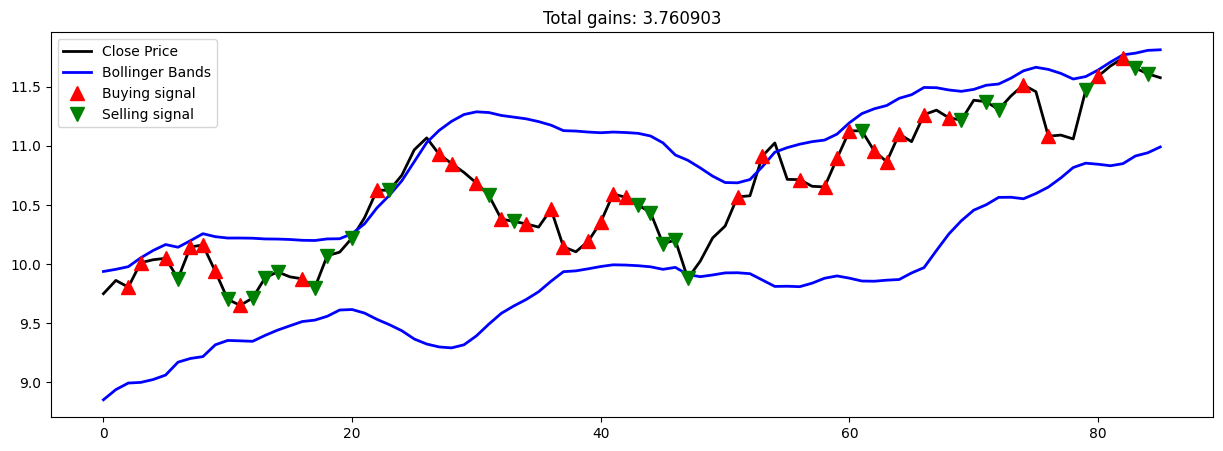

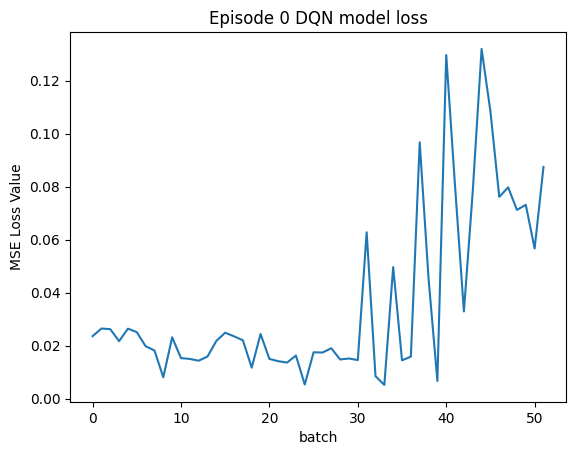

Running episode 1/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 1
Total Profit: -$1.81
Total Winners: $1.65
Total Losers: $3.46
--------------------------------


Running episode 2/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 2
Total Profit: $0.60
Total Winners: $2.65
Total Losers: $2.05
--------------------------------


Running episode 3/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 3
Total Profit: $1.11
Total Winners: $1.55
Total Losers: $0.44
--------------------------------


Running episode 4/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 4
Total Profit: -$0.72
Total Winners: $0.13
Total Losers: $0.84
--------------------------------


Running episode 5/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 5
Total Profit: -$0.82
Total Winners: $0.00
Total Losers: $0.82
--------------------------------


Running episode 6/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 6
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 7/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 7
Total Profit: $8.56
Total Winners: $10.07
Total Losers: $1.51
--------------------------------


Running episode 8/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 8
Total Profit: $0.09
Total Winners: $0.09
Total Losers: $0.00
--------------------------------


Running episode 9/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 9
Total Profit: -$0.04
Total Winners: $0.00
Total Losers: $0.04
--------------------------------


Running episode 10/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 10
Total Profit: -$0.06
Total Winners: $0.00
Total Losers: $0.06
--------------------------------


Running episode 11/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 11
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 12/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 12
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 13/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 13
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 14/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 14
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 15/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 15
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 16/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 16
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 17/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 17
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 18/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 18
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 19/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 19
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 20/100:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.75
Buy: $9.86
Buy: $9.81
Buy: $10.01
Buy: $10.04
Buy: $10.05
Buy: $9.88
Buy: $10.15
Buy: $10.16
Buy: $9.94
Buy: $9.70
Buy: $9.65
Buy: $9.71
Buy: $9.88
Buy: $9.93
Buy: $9.89
Buy: $9.88
Buy: $9.80
Buy: $10.07
Buy: $10.10
Buy: $10.22
Buy: $10.39
Buy: $10.62
Buy: $10.62
Buy: $10.75
Buy: $10.97
Buy: $11.07
Buy: $10.93
Buy: $10.85
Buy: $10.77
Buy: $10.68
Buy: $10.58
Buy: $10.38
Buy: $10.36
Buy: $10.34
Buy: $10.31
Buy: $10.46
Buy: $10.15
Buy: $10.10
Buy: $10.19
Buy: $10.36
Buy: $10.59
Buy: $10.56
Buy: $10.50
Buy: $10.44
Buy: $10.17
Buy: $10.20
Buy: $9.88
Buy: $10.02
Buy: $10.22
Buy: $10.32
Buy: $10.57
Buy: $10.58
Buy: $10.91
Buy: $11.02
Buy: $10.72
Buy: $10.71
Buy: $10.66
Buy: $10.65
Buy: $10.89
Buy: $11.13
Buy: $11.13
Buy: $10.96
Buy: $10.87
Buy: $11.10
Buy: $11.03
Buy: $11.26
Buy: $11.30
Buy: $11.24
Buy: $11.22
Buy: $11.38
Buy: $11.37
Buy: $11.31
Buy: $11.42
Buy: $11.51
Buy: $11.46
Buy: $11.08
Buy: $11.09
Buy: $11.06
Buy: $11.47
Buy: $11.59
Buy: $11.67
Buy: $11.74
Buy: $11.66
Buy: $

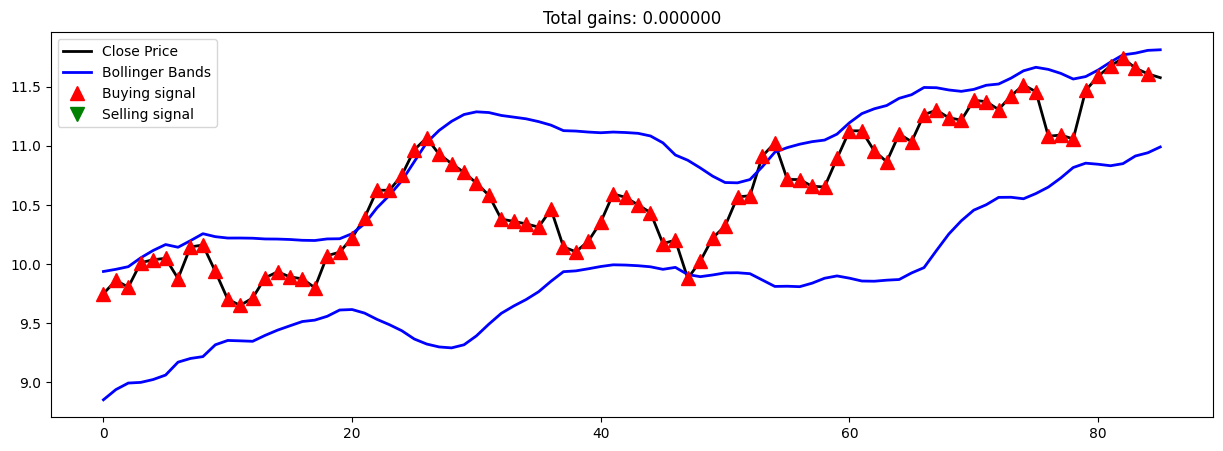

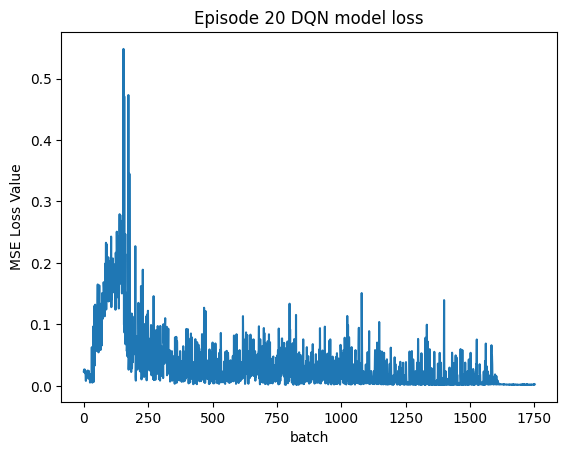

Running episode 21/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 21
Total Profit: $3.65
Total Winners: $3.65
Total Losers: $0.00
--------------------------------


Running episode 22/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 22
Total Profit: -$0.04
Total Winners: $0.00
Total Losers: $0.04
--------------------------------


Running episode 23/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 23
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 24/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 24
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 25/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 25
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 26/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 26
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 27/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 27
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 28/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 28
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 29/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 29
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 30/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 30
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 31/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 31
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 32/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 32
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 33/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 33
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 34/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 34
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 35/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 35
Total Profit: $0.82
Total Winners: $0.82
Total Losers: $0.00
--------------------------------


Running episode 36/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 36
Total Profit: $31.01
Total Winners: $31.01
Total Losers: $0.00
--------------------------------


Running episode 37/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 37
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 38/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 38
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 39/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 39
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 40/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 40
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


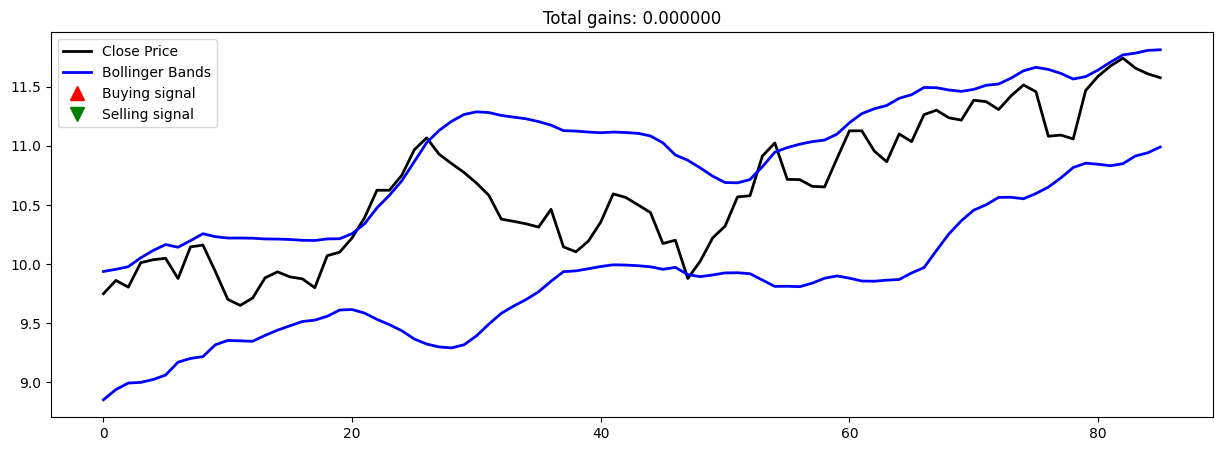

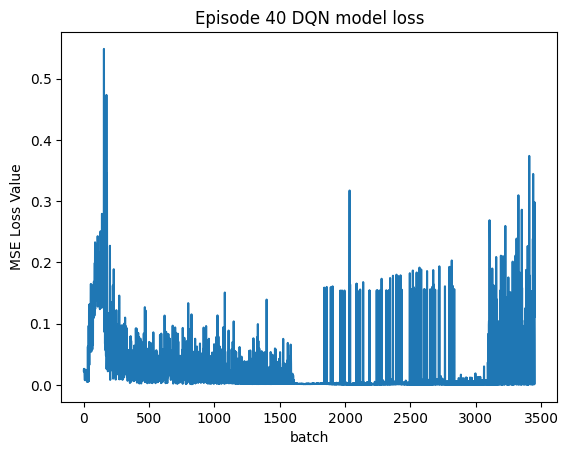

Running episode 41/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 41
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 42/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 42
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 43/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 43
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 44/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 44
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 45/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 45
Total Profit: $0.27
Total Winners: $0.27
Total Losers: $0.00
--------------------------------


Running episode 46/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 46
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 47/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 47
Total Profit: $0.40
Total Winners: $0.40
Total Losers: $0.00
--------------------------------


Running episode 48/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 48
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 49/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 49
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 50/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 50
Total Profit: $1.67
Total Winners: $1.67
Total Losers: $0.00
--------------------------------


Running episode 51/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 51
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 52/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 52
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 53/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 53
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 54/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 54
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 55/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 55
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 56/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 56
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 57/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 57
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 58/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 58
Total Profit: -$0.06
Total Winners: $0.00
Total Losers: $0.06
--------------------------------


Running episode 59/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 59
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 60/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 60
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


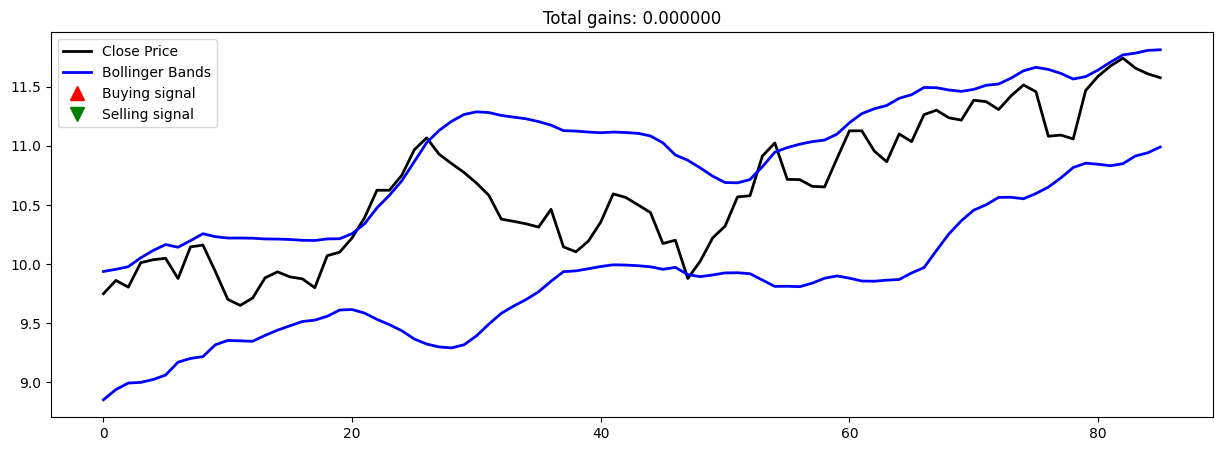

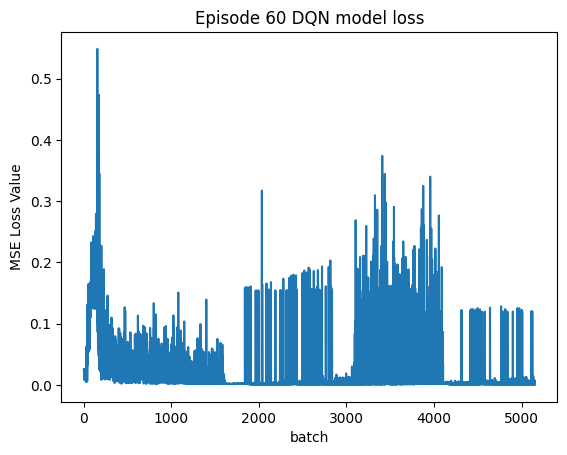

Running episode 61/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 61
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 62/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 62
Total Profit: -$0.24
Total Winners: $0.00
Total Losers: $0.24
--------------------------------


Running episode 63/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 63
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 64/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 64
Total Profit: -$1.31
Total Winners: $0.20
Total Losers: $1.51
--------------------------------


Running episode 65/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 65
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 66/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 66
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 67/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 67
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 68/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 68
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 69/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 69
Total Profit: $9.91
Total Winners: $12.84
Total Losers: $2.93
--------------------------------


Running episode 70/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 70
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 71/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 71
Total Profit: -$0.20
Total Winners: $0.00
Total Losers: $0.20
--------------------------------


Running episode 72/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 72
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 73/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 73
Total Profit: $0.48
Total Winners: $0.48
Total Losers: $0.00
--------------------------------


Running episode 74/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 74
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 75/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 75
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 76/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 76
Total Profit: -$0.05
Total Winners: $0.00
Total Losers: $0.05
--------------------------------


Running episode 77/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 77
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 78/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 78
Total Profit: -$0.02
Total Winners: $0.00
Total Losers: $0.02
--------------------------------


Running episode 79/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 79
Total Profit: $0.09
Total Winners: $0.09
Total Losers: $0.00
--------------------------------


Running episode 80/100:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.10
Sell: $10.22 | Profit: $0.12
--------------------------------
Episode 80
Total Profit: $0.12
Total Winners: $0.12
Total Losers: $0.00
--------------------------------


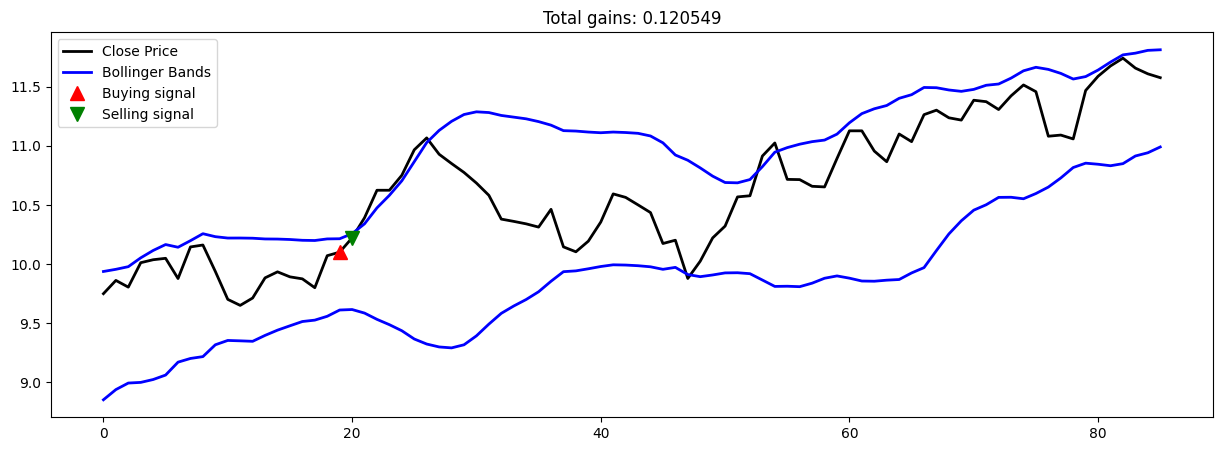

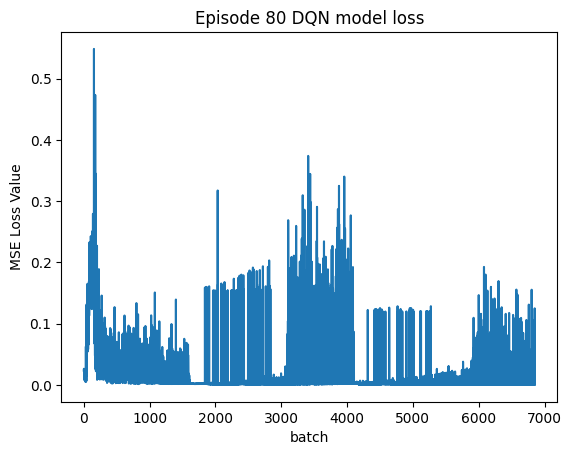

Running episode 81/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 81
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 82/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 82
Total Profit: $0.50
Total Winners: $0.50
Total Losers: $0.00
--------------------------------


Running episode 83/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 83
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 84/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 84
Total Profit: $8.80
Total Winners: $8.80
Total Losers: $0.00
--------------------------------


Running episode 85/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 85
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 86/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 86
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 87/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 87
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 88/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 88
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 89/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 89
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 90/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 90
Total Profit: -$0.09
Total Winners: $0.00
Total Losers: $0.09
--------------------------------


Running episode 91/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 91
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 92/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 92
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 93/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 93
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 94/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 94
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 95/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 95
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 96/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 96
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 97/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 97
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 98/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 98
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 99/100:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 99
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


Running episode 100/100:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.75
Buy: $9.86
Buy: $9.81
Buy: $10.01
Buy: $10.04
Buy: $10.05
Buy: $9.88
Buy: $10.15
Buy: $10.16
Buy: $9.94
Buy: $9.70
Buy: $9.65
Buy: $9.71
Buy: $9.88
Buy: $9.93
Buy: $9.89
Buy: $9.88
Buy: $9.80
Buy: $10.07
Buy: $10.10
Buy: $10.22
Buy: $10.39
Buy: $10.62
Buy: $10.62
Buy: $10.75
Buy: $10.97
Buy: $11.07
Buy: $10.93
Buy: $10.85
Buy: $10.77
Buy: $10.68
Buy: $10.58
Buy: $10.38
Buy: $10.36
Buy: $10.34
Buy: $10.31
Buy: $10.46
Buy: $10.15
Buy: $10.10
Buy: $10.19
Buy: $10.36
Buy: $10.59
Buy: $10.56
Buy: $10.50
Buy: $10.44
Buy: $10.17
Buy: $10.20
Buy: $9.88
Buy: $10.02
Buy: $10.22
Buy: $11.30
Buy: $11.24
Buy: $11.22
Buy: $11.38
Buy: $11.37
Buy: $11.31
Buy: $11.42
Buy: $11.51
Buy: $11.46
Buy: $11.08
Buy: $11.09
Buy: $11.06
Buy: $11.47
Buy: $11.59
Buy: $11.67
Buy: $11.74
Buy: $11.66
Buy: $11.61
--------------------------------
Episode 100
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
--------------------------------


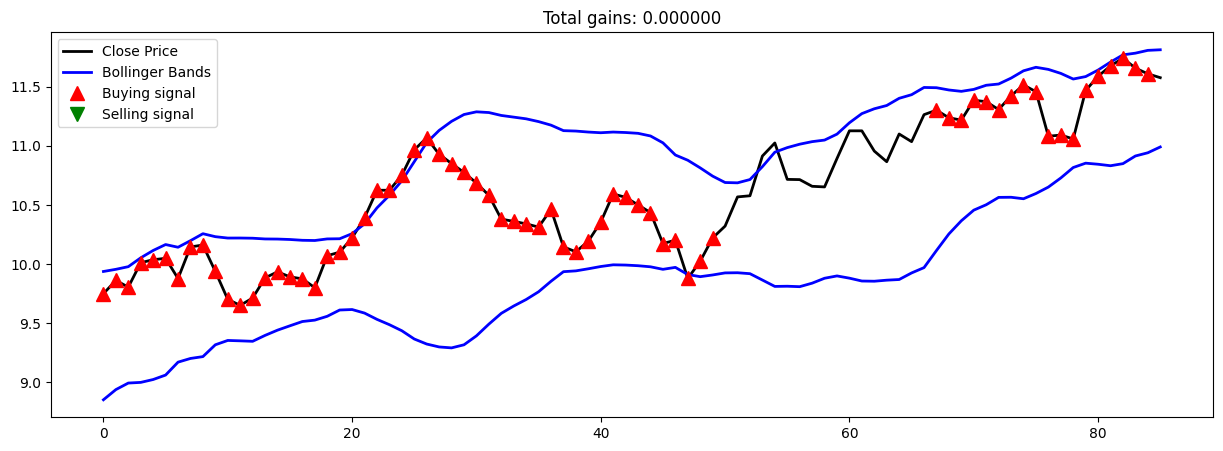

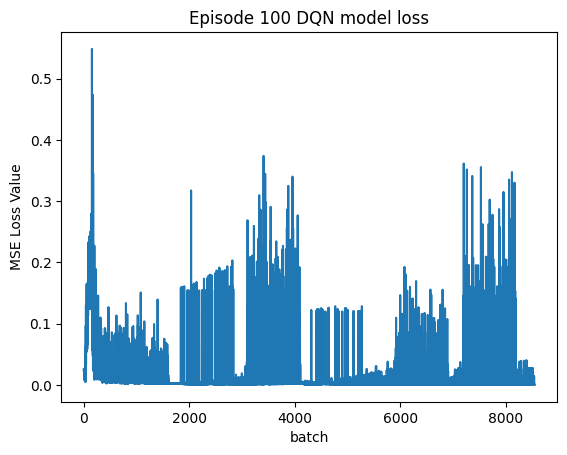

In [24]:
# keras.config.disable_traceback_filtering()

l = len(X_train) - 1
batch_size = 32
episode_count = 100

normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size + 1)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size + 1)
        reward = -0.1  # Small penalty for holding\n

        if action == 1: # buy
            buy_price = X_train_true_price[t]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            if e % 20 == 0:
                print(f"Buy: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)  
            sell_price = X_train_true_price[t]
            trade_profit = sell_price - bought_price
            # Amplify profit incentive
            if trade_profit > 0:
                reward = trade_profit * 2.0  # Double reward for profit
            else:
                reward = trade_profit * 1.5  # Amplify loss to discourage bad trades
            total_profit += trade_profit
            
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += abs(trade_profit)
            states_sell.append(t)
            if e % 20 == 0:
                print(f"Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print('--------------------------------')
            if e % 20 == 0 or e == episode_count:
                plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit, save_path=None)
                plot_losses(batch_losses, f'Episode {e} DQN model loss', save_path=None)
                agent.model.save(f'model_ep{e}.keras')
            
        if len(agent.memory) > batch_size:
            agent.exp_replay(batch_size, batch_losses)
            


### Plot Training Loss

In [25]:
# use the plot_losses function to plot all batch_losses for the entire training round

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [26]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size + 1)

X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1)).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Step 0 Q-Values: [-1.2633315 -1.2613248 -1.2628379] -> Action: 1
Buy: $11.50
Step 1 Q-Values: [-1.2633315 -1.2613248 -1.2628379] -> Action: 1
Buy: $11.35
Step 2 Q-Values: [-1.2633315 -1.2613248 -1.2628379] -> Action: 1
Buy: $11.28
Step 3 Q-Values: [-1.2633315 -1.2613248 -1.2628379] -> Action: 1
Buy: $11.40
Step 4 Q-Values: [-1.2633315 -1.2613248 -1.2628379] -> Action: 1
Buy: $11.49
Buy: $11.42
Buy: $11.56
Buy: $11.73
Buy: $11.76
Buy: $11.83
Buy: $11.89
Buy: $12.16
Buy: $12.25
Buy: $12.25
Buy: $12.38
Buy: $12.43
Buy: $12.41
Buy: $12.37
Buy: $12.27
Buy: $12.42
Buy: $12.42
Buy: $12.35
Buy: $12.13
Buy: $12.07
Buy: $12.17
Buy: $12.42
Buy: $12.89
Buy: $12.81
Buy: $12.86
Buy: $13.05
Buy: $13.10
Sell: $13.33 | Profit: $1.83
Buy: $13.20
Buy: $13.69
Buy: $13.75
Buy: $13.74
Buy: $13.73
Buy: $13.80
Buy: $13.79
Buy: $13.80
Buy: $13.66
Buy: $13.46
Buy: $13.72
Buy: $13.35
Buy: $13.30
Buy: $13.38
Buy: $13.46
Buy: $13.67
Sell: $13.73 | Profit: $2.37
Sell: $14.01 | Profit: $2.73
Sell: $14.12 | Profit: $

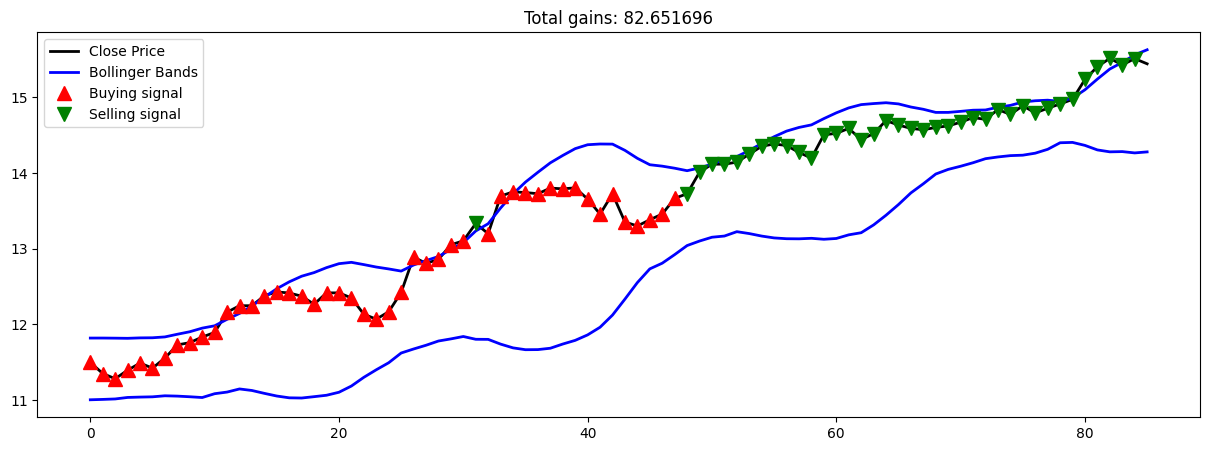

In [27]:
for t in range(l_test):
    if t < 5:
        q = agent.get_q_values_for_state(state)[0]
        print(f"Step {t} Q-Values: {q} -> Action: {np.argmax(q)}")
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size + 1)
    reward = -0.1  # Small penalty for holding

    if action == 1: # buy
        buy_price = X_test_true_price[t]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        sell_price = X_test_true_price[t]
        trade_profit = sell_price - bought_price
        total_profit += trade_profit
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

    if t == l_test - 1:
        done = True
    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False, save_path=None)